# Taxi Prediction and Routing

Authors: Kentaro Hoffman and Benjy Leinwand

Abstract: The goal of this project is two fold-Create and compare predictive models for taxi rides in New York City, and create an algorithm to tell taxi drivers where they should go to pick up the most fares.

Data:

The data comes from NYC's open data Project (https://data.cityofnewyork.us/dataset/2016-Yellow-Taxi-Trip-Data/uacg-pexx). It was collected in 2016, from Yellow Cab Taxis in NYC and contains information such as:
* Pickup Date/time
* Pickup Location
* Dropoff Date/time
* Dropoff Location
* Trip Distance



## Part 1: Predicting Future Demand

In this part, our goal is to predict, for each zip code and hour from January 1st 2016- June 30th 2016, create a model that will forcast the number of people who were picked up by taxis. Higher number of people picked up by taxis hopefully representing where there is higher demand for taxis. To test this, we started by splitting our data into a training set (All the data from months January-May) and testing data (All the data in June) and seeing which of these models would predict better.

**SUMMARY OF THE DATA HERE**

## ARIMA

## LSTM

In [7]:
#LSTM
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(7)





In [8]:
#Choose which zip code to Model
zip = 10001

In [12]:
#Process the Data
dataframe = pandas.read_csv('Demand_Data2.csv', usecols=[2,3], engine='python', skipfooter=3)
dataframe = dataframe[dataframe['pickup_zip'] == 10001]
dataframe = dataframe['passenger_count']
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset = dataset[0:24*100]
dataset = np.reshape(dataset, (len(dataset),1))

#Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#Training/Testing Data
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
#model.add(LSTM(1, input_shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=10, verbose=2)



plt.show()

1608 792
Epoch 1/10
 - 1s - loss: 0.1054
Epoch 2/10
 - 0s - loss: 0.0309
Epoch 3/10
 - 0s - loss: 0.0223
Epoch 4/10
 - 0s - loss: 0.0169
Epoch 5/10
 - 0s - loss: 0.0128
Epoch 6/10
 - 0s - loss: 0.0107
Epoch 7/10
 - 0s - loss: 0.0100
Epoch 8/10
 - 0s - loss: 0.0099
Epoch 9/10
 - 0s - loss: 0.0099
Epoch 10/10
 - 0s - loss: 0.0099


In [13]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 #invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))




Train Score: 403.31 RMSE
Test Score: 169.23 RMSE


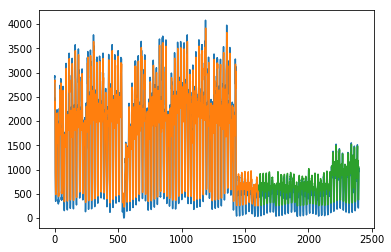

In [17]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)